In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
import os
import re
import sys
import glob
import codecs
import pathlib

from tqdm import tqdm
import slugify

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import utils

In [19]:
RAW_PATH = r"D:\Data\peace-speech-project\raw" #None
sources_files = utils.get_sources_files(path=RAW_PATH)
text_folders = utils.get_text_folders(path=RAW_PATH)

print("Number of Sources Files: ", len(sources_files))
print("Number of Text Folders: ", len(text_folders))

Number of Sources Files:  49
Number of Text Folders:  129


In [37]:
%%time

MAX_ARTICLES = np.inf
SOURCES_SET = sources_files[37:38]

bad_lines_list, summary_stats, file_lookup, no_text_articles = [], [], [], []
current_year, current_month = None, None
for i, sources_file in enumerate(SOURCES_SET, 1): 
    print(f"Source file ({i:>02}/{len(SOURCES_SET):>02}): {sources_file}... ", end="", flush=True)
    
    sources = utils.read_sources_file(sources_file)
    sources["month"] = sources["date"].dt.month
    sources["year"] = sources["date"].dt.year
    
    sources_groups = sources.groupby(["year", "month", "country"])
    for (year, month, country), country_df in sources_groups:
            
        success = "Yes"
        if (
            sources["year"].unique().shape[0] > 1 and
            (year != current_year or month != current_month)
        ):
            print(f"\n  {utils.format_year(year)}-{utils.format_month(month)}: ", end="", flush=True)
            current_year, current_month = year, month
        
        if country != "PK":
            continue
            
        print(country, end=", ", flush=True)
        
        try:
            text_file_paths = utils.get_text_file_paths(text_folders, year, month, country, path=RAW_PATH)
        except:
            text_file_paths = None
            success = "No"
        
        if text_file_paths:
            text_data_list = []
            for text_file_path in text_file_paths:
                success = "Yes"
                try:
                    text_data, bad_lines = utils.read_text_file(text_file_path)
                    text_data_list.append(text_data)
                    
                    if len(bad_lines) > 0:
                        success = "Partial"
                        bad_lines_list.append((year, month, country, text_file_path, bad_lines))
                except:
                    success = "No"
                    
                file_lookup.append((year, month, country, sources_file, text_file_path, success))

                
            if text_data_list:
                if len(text_data_list) > 1:
                    text_data = pd.concat(text_data_list)
                else:
                    text_data = text_data_list[0]
        else:
            file_lookup.append((year, month, country, sources_file, text_file_paths, success))
        
        for publisher, publisher_df in country_df.groupby("website"):
            

            if success != "No":
                to_export = publisher_df.merge(text_data, how="left", on="id")

                if country == "UK":
                    to_export["country"] = to_export["country"].apply(lambda x: "GB" if x == "UK" else x)
                
                if to_export.shape[0] > MAX_ARTICLES:
                    to_export = to_export.sample(MAX_ARTICLES)
                
                no_text_articles.append(to_export[to_export.text.isna()].copy())
                to_export = to_export[~to_export.text.isna()].copy()
                
                to_export["export_path"] = to_export.apply(utils.export_report, axis=1, 
                                                           path=r"D:\Data\peace-speech-project\test")
                
            if slugify.slugify(publisher) == "oyeyeah-com":
                problem_publisher_df = publisher_df.copy()
                problem_to_export = to_export.copy()
                
            summary_stats.append((year, month, country, publisher, 
                                  *utils.get_basic_summary_stats(publisher_df)))
    
    print()
    
# summary_stats_df = pd.DataFrame(summary_stats, columns=["year", "month", "country", "publisher", "num_articles", "total_words"])
# summary_stats_df.to_csv("data/summary_stats.csv", index=False)

# file_lookup_df = pd.DataFrame(file_lookup, columns=["year", "month", "country", "source_file", "text_file", "success"])
# file_lookup_df.to_csv("data/file_lookup.csv", index=False)

Source file (01/01): D:\Data\peace-speech-project\raw\sources-19-10.txt... PK, text-19-10
['D:\\Data\\peace-speech-project\\raw\\text-19-10\\19-10-au.txt', 'D:\\Data\\peace-speech-project\\raw\\text-19-10\\19-10-bd.txt', 'D:\\Data\\peace-speech-project\\raw\\text-19-10\\19-10-ca.txt', 'D:\\Data\\peace-speech-project\\raw\\text-19-10\\19-10-gb1.txt', 'D:\\Data\\peace-speech-project\\raw\\text-19-10\\19-10-gb2.txt', 'D:\\Data\\peace-speech-project\\raw\\text-19-10\\19-10-gh.txt', 'D:\\Data\\peace-speech-project\\raw\\text-19-10\\19-10-hk.txt', 'D:\\Data\\peace-speech-project\\raw\\text-19-10\\19-10-ie.txt', 'D:\\Data\\peace-speech-project\\raw\\text-19-10\\19-10-in.txt', 'D:\\Data\\peace-speech-project\\raw\\text-19-10\\19-10-jm.txt', 'D:\\Data\\peace-speech-project\\raw\\text-19-10\\19-10-ke.txt', 'D:\\Data\\peace-speech-project\\raw\\text-19-10\\19-10-lk.txt', 'D:\\Data\\peace-speech-project\\raw\\text-19-10\\19-10-my.txt', 'D:\\Data\\peace-speech-project\\raw\\text-19-10\\19-10-ng.txt

In [39]:
pd.concat(no_text_articles)

id  n_words       date country                    website  \
36   81713315      252 2019-10-20      PK                    SUCH TV   
14   81780429      185 2019-10-24      PK  Wisconsinagconnection.com   
3    51071931      151 2019-10-01      PK                 arynews.tv   
7    51071702      132 2019-10-01      PK                 arynews.tv   
14   51071711      620 2019-10-01      PK                 arynews.tv   
..        ...      ...        ...     ...                        ...   
24   51088704     1067 2019-10-06      PK         tns.thenews.com.pk   
60   51102785     1000 2019-10-12      PK         tns.thenews.com.pk   
89   51122341     1185 2019-10-19      PK         tns.thenews.com.pk   
90   51122342     1151 2019-10-19      PK         tns.thenews.com.pk   
113  51129363     1346 2019-10-22      PK         tns.thenews.com.pk   

                                                   url  \
36   https://www.suchtv.pk/pakistan/general/item/90...   
14   http://www.wisconsinagconnection.com/story-nat...   
3    https://arynews.tv/en/students-boycott-classes...   
7    https://arynews.tv/en/speaker-malaysia-role-ka...   
14   https://arynews.tv/en/vape-product-concerns-we...   
..                                                 ...   
24                 http://tns.thenews.com.pk/division/   
60    http://tns.thenews.com.pk/rejected-less-90-days/   
89   http://tns.thenews.com.pk/brief-history-urdu-m...   
90    http://tns.thenews.com.pk/kate-middleton-effect/   
113  http://tns.thenews.com.pk/lahore-city-ever-sin...   

                                                 title  month  year text  
36    Azadi March: JUI-F cancels talks with government     10  2019  NaN  
14   Biofuels, Ag Group Coalition Challenges EPA on...     10  2019  NaN  
3    Students boycott classes after young woman's d...     10  2019  NaN  
7    NA speaker urges Malaysia to play effective ro...     10  2019  NaN  
14   Vape product concerns weigh on cannabis compan...     10  2019  NaN  
..                                                 ...    ...   ...  ...  
24   Review: The State During the British Raj by Il...     10  2019  NaN  
60   Rejected in less than 90 days | TNS - The News...     10  2019  NaN  
89   How influential were global art movements in P...     10  2019  NaN  
90   The Kate Middleton effect | TNS - The News on ...     10  2019  NaN  
113  "Lahore has been my city ever since" - III | T...     10  2019  NaN  

[187 rows x 10 columns]

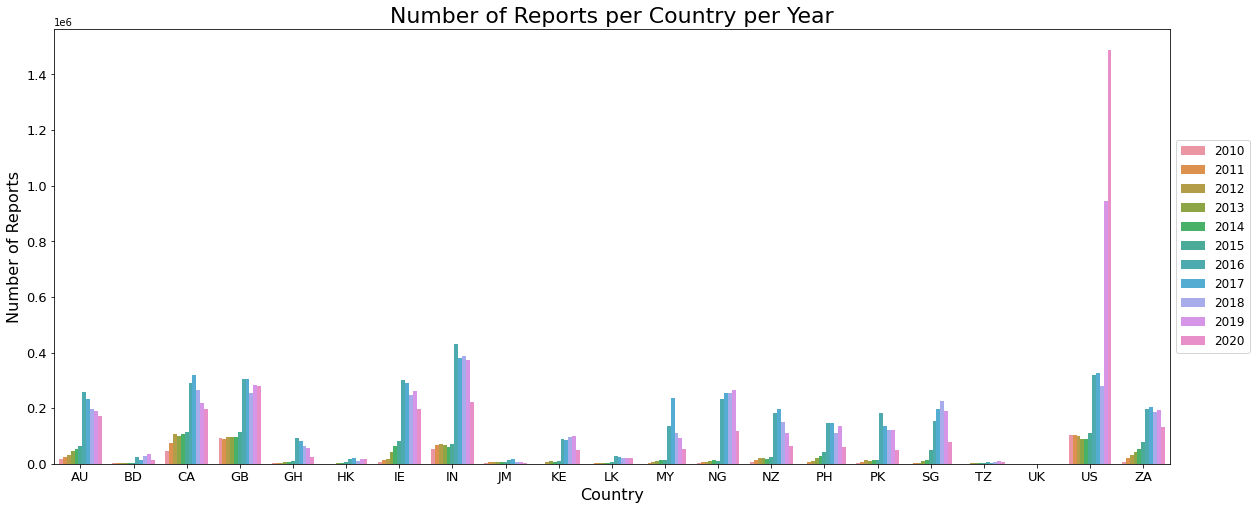

In [5]:
summary_by_country_by_year = summary_stats_df.groupby(["country", "year"])
summary_by_country_by_year = summary_by_country_by_year[["num_articles", "total_words"]]
summary_by_country_by_year = summary_by_country_by_year.sum().reset_index()

fig, ax = plt.subplots(figsize=(20, 8))
sns.barplot(
    x="country", 
    y="num_articles", 
    hue="year",
    data=summary_by_country_by_year,
    ax=ax
)

ax.set_xlabel("Country", fontsize=16)
ax.set_ylabel("Number of Reports", fontsize=16)
ax.set_title("Number of Reports per Country per Year", fontsize=22)

ax.tick_params(axis='both', which='major', labelsize=13)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12);

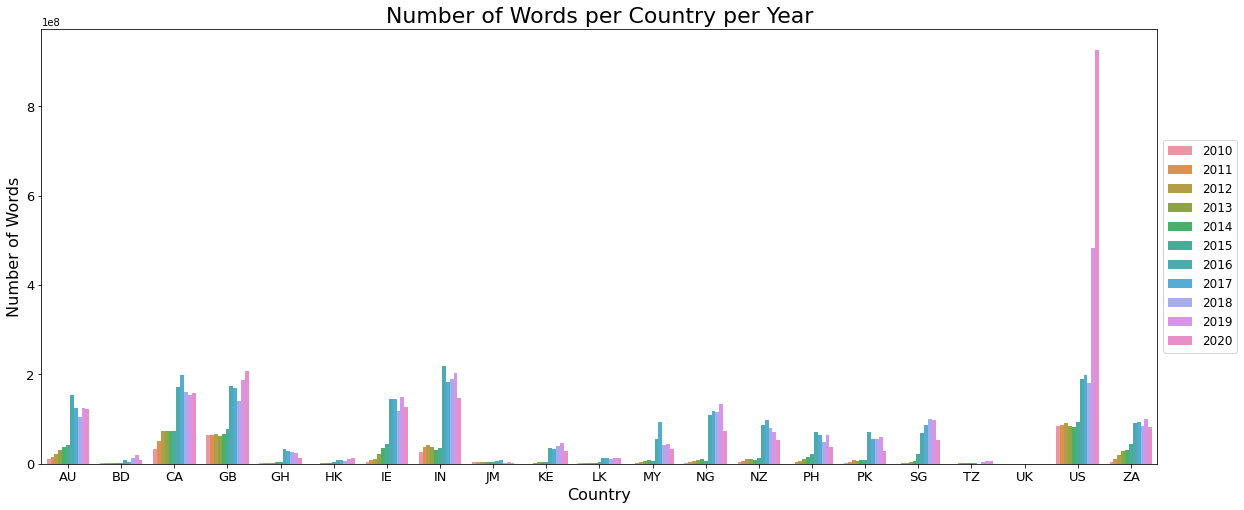

In [6]:
fig, ax = plt.subplots(figsize=(20, 8))
sns.barplot(
    x="country", 
    y="total_words", 
    hue="year",
    data=summary_by_country_by_year,
    ax=ax
)
ax.set_xlabel("Country", fontsize=16)
ax.set_ylabel("Number of Words", fontsize=16)
ax.set_title("Number of Words per Country per Year", fontsize=22)

ax.tick_params(axis='both', which='major', labelsize=13)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12);

In [7]:
by_publisher = summary_stats_df.groupby(["country", "publisher"])
by_publisher = by_publisher[["num_articles", "total_words"]]
by_publisher = by_publisher.sum().reset_index()

by_publisher["number_of_aticles"] = pd.cut(by_publisher.num_articles, 
                             bins=[0, 1, 2, 3, 5, 10, 25, 100, 500, 1000, np.inf], 
                             labels=["1", "2", "3", "4-5", "6-10", "11-25", "26-100", "101-500", "510-1000", "1000+"])


by_bin = by_publisher.groupby("number_of_aticles").publisher.count().reset_index()
by_bin.rename(columns={"publisher": "num_publishers"}, inplace=True)
by_bin["pct_publishers"] = by_bin.num_publishers / by_bin.num_publishers.sum()
by_bin["cum_pct_publishers"] = by_bin.pct_publishers.cumsum()

by_bin["num_articles"] = by_publisher.groupby("number_of_aticles").num_articles.sum().values
by_bin["pct_articles"] = by_bin.num_articles / by_bin.num_articles.sum()
by_bin["cum_pct_articles"] = by_bin.pct_articles.cumsum()

by_bin

number_of_aticles  num_publishers  pct_publishers  cum_pct_publishers  \
0                 1            6762        0.180812            0.180812   
1                 2            3256        0.087063            0.267875   
2                 3            1968        0.052623            0.320498   
3               4-5            2540        0.067918            0.388416   
4              6-10            3312        0.088561            0.476977   
5             11-25            4171        0.111530            0.588507   
6            26-100            5488        0.146746            0.735253   
7           101-500            5321        0.142280            0.877534   
8          510-1000            1586        0.042409            0.919942   
9             1000+            2994        0.080058            1.000000   

   num_articles  pct_articles  cum_pct_articles  
0          6762      0.000335          0.000335  
1          6512      0.000323          0.000657  
2          5904      0.000292          0.000950  
3         11250      0.000557          0.001507  
4         25581      0.001267          0.002774  
5         69968      0.003465          0.006239  
6        292778      0.014500          0.020740  
7       1266238      0.062713          0.083453  
8       1124211      0.055679          0.139131  
9      17381823      0.860869          1.000000

In [12]:
utils.get_basic_summary_stats(publisher_df)

(93, 45954)

In [13]:
utils.get_basic_summary_stats(to_export)

(2, 674)

In [14]:
to_export

id  n_words       date country     website  \
0  85843308      234 2020-09-03      UK  Nexus Mods   
1  85908958      440 2020-09-11      UK  Nexus Mods   

                                               url  \
0  https://www.nexusmods.com/fallout4/videos/11764   
1             https://www.nexusmods.com/news/14358   

                                               title  month  year text  
0  Fallout 4 - Workin on The Railroad - No Settle...      9  2020  NaN  
1                    We The Players Winners - August      9  2020  NaN

In [18]:
publisher_df.merge(text_data, how="left", on="id")

id  n_words       date country        website  \
0   62111472      291 2020-09-08      ZA  zoutnet.co.za   
1   62117392      370 2020-09-10      ZA  zoutnet.co.za   
2   62117393      299 2020-09-10      ZA  zoutnet.co.za   
3   62117394      293 2020-09-10      ZA  zoutnet.co.za   
4   62116691      359 2020-09-10      ZA  zoutnet.co.za   
..       ...      ...        ...     ...            ...   
88  62155543      442 2020-09-27      ZA  zoutnet.co.za   
89  62159189      415 2020-09-28      ZA  zoutnet.co.za   
90  62158648      739 2020-09-28      ZA  zoutnet.co.za   
91  62160408      396 2020-09-29      ZA  zoutnet.co.za   
92  62163445      737 2020-09-30      ZA  zoutnet.co.za   

                                                  url  \
0   https://zoutnet.co.za/articles/entertainment/5...   
1   https://www.zoutnet.co.za/articles/news/53092/...   
2   https://www.zoutnet.co.za/articles/newsflash/5...   
3   https://www.zoutnet.co.za/articles/sport/53094...   
4   https://www.zoutnet.co.za/articles/entertainme...   
..                                                ...   
88  https://www.zoutnet.co.za/articles/entertainme...   
89  https://www.zoutnet.co.za/articles/news/53171/...   
90  https://www.zoutnet.co.za/articles/news/53166/...   
91  https://www.zoutnet.co.za/articles/entertainme...   
92  https://zoutnet.co.za/articles/letters/53141/2...   

                                                title  month  year  \
0   Zoutnet | Entertainment | Queen Popoo's "Daddy...      9  2020   
1   Zoutnet | News | Young man stabbed to death at...      9  2020   
2   Zoutnet | News in brief | Temporary house for ...      9  2020   
3      Zoutnet | Sport | Mabena tournament called off      9  2020   
4   Zoutnet | Entertainment | Oga Stone is in the ...      9  2020   
..                                                ...    ...   ...   
88  Zoutnet | Entertainment | Comza Mabebeza knows...      9  2020   
89  Zoutnet | News | Mpho Mathabi needs no arms to...      9  2020   
90  Zoutnet | News | Tendani is testimony that a s...      9  2020   
91  Zoutnet | Entertainment | Dr Roxley Masevhe sh...      9  2020   
92  Zoutnet | Letters | South Africa does need dev...      9  2020   

                                                 text  
0   <h> Queen Popoo 's " Daddy " may be one of bes...  
1   <h> Young man stabbed to death at tavern <p> N...  
2   <h> Temporary house for Masisi family <p> News...  
3   <h> Mabena tournament called off <p> Sport - D...  
4   <h> Oga Stone is in the Afropop house <p> Oga ...  
..                                                ...  
88  <h> Comza Mabebeza knows that her time is here...  
89  <h> Mpho Mathabi needs no arms to be an everyd...  
90  <h> Tendani is testimony that a stroke needs n...  
91  <h> Dr Roxley Masevhe shines with books <p> En...  
92  <h> South Africa does need development , but n...  

[93 rows x 10 columns]